In [1]:
%run master_functions.ipynb

# Load solute parameters

In [2]:
def load_parameters(solutes, nclusters, linkage='ward'):

    params = {i : {} for i in solutes}
    
    for n, s in zip(nclusters, solutes):
        
        if s != 'GCL':
            ihmm = file_rw.load_object('saved_parameters/2000iter_%s_unseeded.pl' % s)['ihmm']
        else:
            ihmm = file_rw.load_object('saved_parameters/2000iter_%s.pl' % s)['ihmm']

        A, sigma, mu, T, mu_weights = organize_parameters(ihmm) # arrange parameters into arrays suitable for clustering
        
        params[s]['z'] = file_rw.load_object('clusters_%s_%s.pl' %(s, linkage))[0][n]['z']
        params[s]['final_parameters'] = file_rw.load_object('clusters_%s_%s.pl' %(s, linkage))[0][n]
        
        params[s]['unclustered_params'] = {'A': A, 'sigma': sigma, 'mu': mu, 'T': T, 'mu_weights': mu_weights}
        
        params[s]['density'] = get_density(s)
        params[s]['coord'] = get_coordination(s)
        params[s]['hbonded'], params[s]['monomer_hbonds'], params[s]['definitions'] = get_hbonds(s)
        params[s]['unclustered_realizations'] = file_rw.load_object('unclustered_%s.pl' % s)
        
    return params

In [3]:
solutes = ['MET', 'GCL', 'URE', 'ACH']
nclusters = [10, 10, 10, 10]

params = load_parameters(solutes, nclusters)

# Plot time spent hbonding and associated with sodium

In [4]:
def hbonded_associated(residues, params, bar_width=0.75, bar_cmap = plt.cm.cool, savename=None):
    
    fig, haax = plt.subplots(figsize=(6, 4.5))
    names = {'MET': 'methanol', 'URE': 'urea', 'GCL': 'ethylene\n glycol', 'ACH': 'acetic\n acid'}
    
    for i, r in enumerate(residues):
    
        z = params[r]['z']
        hbonded = params[r]['hbonded']
        coordinated = params[r]['coord']
        nsolute = hbonded.shape[0]
        
        nclusters = np.unique(z).size
        interactions = np.zeros([nclusters, 3])  # [hbonded, both, associated]

        both = 0
        only_hbonded = 0
        only_coord = 0

        for t in range(nsolute):
            
            zipped = np.array([hbonded[t, :], coordinated[t, :]]).astype(bool)

            both += len(np.where(zipped.sum(axis=0) == 2)[0])

            not_both_ndx = np.where(zipped.sum(axis=0) < 2)[0]
            only_hbonded += len(np.where(zipped[0, not_both_ndx])[0])
            only_coord += len(np.where(zipped[1, not_both_ndx])[0])

            for s in range(np.unique(z).size):

                ndx = np.where(z[t, :] == s)[0]

                data = zipped[:, ndx]

                not_both = np.where(data.sum(axis=0) < 2)[0]

                interactions[s, 1] += len(np.where(data.sum(axis=0) == 2)[0])
                interactions[s, 0] += len(np.where(data[0, not_both])[0])
                interactions[s, 2] += len(np.where(data[1, not_both])[0])

        bar_colors = np.array([bar_cmap(j) for j in np.linspace(50, 250, 4).astype(int)])

        tot = z.size
        both /= tot
        only_hbonded /= tot
        only_coord /= tot

        #msd = file_rw.load_object('trajectories/%s_msd.pl' % res)

        haax.bar(i, only_hbonded, bar_width, color=bar_colors[0], edgecolor='white', linewidth=1)
        haax.bar(i, both, bar_width, bottom=only_hbonded, color=bar_colors[1], edgecolor='white', linewidth=1)
        haax.bar(i, only_coord, bar_width, bottom=only_hbonded + both, color=bar_colors[2], edgecolor='white', linewidth=1)
        #msdax.bar(i + bar_width/2, msd.MSD.mean(axis=1)[2000], bar_width, color=bar_colors[3], edgecolor='white', lw=2)

    haax.tick_params(labelsize=14)
    haax.set_xticks([0, 1, 2, 3])
    haax.set_xticklabels([names[res] for res in residues])
    haax.set_ylabel('Fraction of time spent interacting', fontsize=14)
    haax.set_ylim(0, 1)

#     msdax.tick_params(labelsize=14)
#     msdax.set_ylim(0, 4.5)
#     msdax.set_ylabel('Mean Squared Displacement', fontsize=14)

    hatches = []
    labels = ['Hbonded', 'Both', 'Associated']
    for i in range(3):
        hatches.append(mpatches.Patch(facecolor=bar_colors[i], label=labels[i], edgecolor='white'))

    fig.legend(handles=hatches, fontsize=14, ncol=3, loc='upper left', bbox_to_anchor=(0.15, 0.94), 
               columnspacing=0.9, frameon=False)
    fig.tight_layout()
    
    if savename is not None:
        
        fig.savefig(savename)


In [ ]:
save = True

if save:
    savename = '/home/ben/github/LLC_Membranes/Ben_Manuscripts/hdphmm/figures/hbonds_assoc_summary.pdf'
else:
    savename = None

hbonded_associated(solutes, params, bar_width=0.75, bar_cmap=plt.cm.cool, savename=savename)

# Plot radial distribution functions based on clustered parameters

In [ ]:
def rdf(residues, params, cmap=plt.cm.jet, savename=None):
    
    colors = np.array([cmap(i) for i in np.linspace(50, 225, len(residues)).astype(int)])
    colors = ['xkcd:red', 'xkcd:green', 'xkcd:blue', 'xkcd:orange']
    names = {'MET': 'methanol', 'URE': 'urea', 'GCL': 'ethylene glycol', 'ACH': 'acetic acid'}
    
    fig, rdfax = plt.subplots(len(residues), 1, sharex=True, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(6, 4.5))
    
    for i, r in enumerate(residues):
        
        z = params[r]['z']
        mu = params[r]['unclustered_params']['mu']
        mu_weights = params[r]['unclustered_params']['mu_weights']

        mur = np.linalg.norm(mu[:2, :], axis=0)
        rdf = []
        for j, m in enumerate(mur):
            rdf += [m] * mu_weights[j]
            
        nbins = 15
        n, edges = np.histogram(rdf, range=(0, 3), bins=15, density=True)
        x = np.zeros([2 * nbins + 2])
        y = np.zeros_like(x)
        x[1::2] = edges
        x[2::2] = edges[:-1]
        x += edges[1] - edges[0]
        y[:-2:2] = n
        y[1:-1:2] = n
        rdfax[i].plot(x, y, color=colors[i], lw=2)
        rdfax[i].hist(rdf, bins=15, range=(0, 3), color=colors[i], density=True, alpha=0.7)
        rdfax[i].set_ylim(0, 2)
        rdfax[i].set_yticks([1, 2])
        rdfax[i].tick_params(labelsize=14)
        hatch = mpatches.Patch(facecolor='xkcd:white', label=names[r], edgecolor='white')
        rdfax[i].legend(handles = [hatch], loc='upper right', frameon=False, fontsize=14)

    
    rdfax[2].set_ylabel('          Cluster frequency', fontsize=14)
    rdfax[3].set_xlabel('Radial distance from nearest pore center (nm)', fontsize=14)
    fig.tight_layout()
    
    if savename is not None:
        fig.savefig(savename)



In [ ]:
save = True

if save:
    savename = '/home/ben/github/LLC_Membranes/Ben_Manuscripts/hdphmm/figures/rdf_summary.pdf'
else:
    savename = None
    
rdf(solutes, params, savename=savename, cmap=plt.cm.prism)

# Compare longest dwell times of prevelant states

In [10]:
def dwell_time_comparison(residues, params, msds, cmap=plt.cm.jet, savename=None, dt=0.5, bar_width=0.6):
    
    colors = np.array([cmap(i) for i in np.linspace(50, 225, len(residues)).astype(int)])
    colors = ['xkcd:red', 'xkcd:green', 'xkcd:blue', 'xkcd:orange']
    
    names = {'MET': 'methanol', 'URE': 'urea', 'GCL': 'ethylene glycol', 'ACH': 'acetic acid'}
    
    fig, ax = plt.subplots(figsize=(6, 4.5))
    #ax2 = ax.twinx()
    
    ax_color = 'xkcd:azure'
    ax2_color = 'xkcd:aquamarine'
    
    for i, r in enumerate(residues):
        
#         T = params[r]['final_parameters']['T']
        z = params[r]['z']
        
        dwells = []
        dwells_perparticle = []
        for t in range(24):
            sp = ts.switch_points(z[t, :])
            dwells += (sp[1:] - sp[:-1]).tolist()
            dwells_perparticle.append((sp[1:] - sp[:-1]).tolist())
        
        #prevelant_states, state_counts = prevalent_states(z, percent=50)  # states that are at least half of trajectories
        
        #max_selfT_ndx = prevelant_states[np.argmax(np.diag(T.mean(axis=0))[prevelant_states])]
        #max_selfT = T[:, max_selfT_ndx, max_selfT_ndx]
        
        dwells = np.array(dwells)
        dwell_boot = []
        for b in range(200):
            ndx = np.random.choice(len(dwells), size=len(dwells), replace=True)
            dwell_boot.append(np.percentile(dwells[ndx], 95))
        
#         dwells = dt / (1 - max_selfT)
#         yerr = np.abs(np.array([[np.percentile(dwells, 16), np.percentile(dwells, 84)]]).T - dwells.mean())
#         ax.bar(i - bar_width/2, dwells.mean(), bar_width, color=ax_color, yerr=yerr)
#         ax.bar(i - bar_width/2, dt*np.mean(dwell_boot), bar_width, color=ax_color, yerr=dt*np.std(dwell_boot))
#         ax2.bar(i + bar_width/2, msds[r][0], bar_width, yerr=msds[r][1], color=ax2_color)
        #ax.scatter(msds[r][0], np.mean(dwell_boot), color=colors[i])
        #ax.scatter(np.mean(dwell_boot), msds[r][0], color=colors[i])
        ax.errorbar(dt*np.mean(dwell_boot), msds[r][0], xerr=dt*np.std(dwell_boot), yerr=msds[r][1],
                    color=colors[i], marker='D', capsize=5, capthick=2)
    
#     ax.set_xticks([0, 1, 2, 3])
#     ax.set_xticklabels([names[r] for r in residues], fontsize=14)
    #ax.invert_yaxis()
    ax.set_xticks([50, 100, 150, 200, 250])
    ax.set_ylabel('MSD after 1000 ns (nm$^2$)', fontsize=14)
    ax.set_xlabel('95$^{th}$ Percentile Dwell Time (ns)', fontsize=14)
    ax.tick_params(labelsize=14)#, axis='y', color=ax_color)
    
    handles = []
    for i, r in enumerate(residues):
        handles.append(mlines.Line2D([], [], color=colors[i], marker='D', label=names[r]))
    
    labels = [h.get_label() for h in handles]
    
    ax.legend(handles, labels, fontsize=14)
    
    #fig.legend(handles=[hatch1, hatch2], fontsize=14, loc='lower left', bbox_to_anchor=(0.38, 0.15))
    
#     ax2.tick_params(labelsize=14, axis='y', colors=ax2_color)
#     ax2.set_ylabel('MSD after 1000 ns (nm$^2$)', fontsize=14)
#     ax.spines['left'].set_color(ax_color)
#     ax.spines['right'].set_color(ax2_color)
    
    fig.tight_layout()
    
    if savename is not None:
        fig.savefig(savename)
        
    plt.show()
    

In [6]:
z = params['ACH']['z']
dwells = []
dwells_perparticle = []
for t in range(24):
    sp = ts.switch_points(z[t, :])
    dwells += (sp[1:] - sp[:-1]).tolist()
    dwells_perparticle.append((sp[1:] - sp[:-1]).tolist())

dwells = np.array(dwells)
dwell_boot = []
for i in range(200):
    ndx = np.random.choice(len(dwells), size=len(dwells), replace=True)
    dwell_boot.append(np.percentile(dwells[ndx], 95))
    
dwells_perparticle = np.array(dwells_perparticle)
dwells_perparticle_boot = []
for i in range(200):
    ndx = np.random.choice(z.shape[0], size=z.shape[0], replace=True)
    boot = []
    for n in ndx:
        boot += dwells_perparticle[n]
    dwells_perparticle_boot.append(np.percentile(boot, 95))
    
print(np.mean(dwell_boot), np.std(dwell_boot))
print(np.mean(dwells_perparticle_boot), np.std(dwells_perparticle_boot))
#np.percentile(dwells, 95)


451.0469999999994 44.638641231560534
454.5979999999997 93.8315205354789


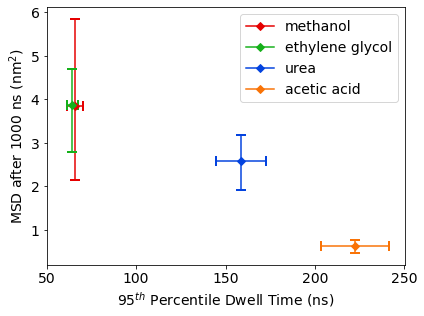

In [11]:
msds = dict()
timelag = 2000

for s in solutes:
    msd = file_rw.load_object('trajectories/%s_msd.pl' % s)
    msds[s] = (msd.MSD_average[timelag], msd.limits[:, [timelag]])

save = True

if save:
    savename = '/home/ben/github/LLC_Membranes/Ben_Manuscripts/hdphmm/figures/dwell_time_summary.pdf'
else:
    savename = None
    
dwell_time_comparison(solutes, params, msds, savename=savename, cmap=plt.cm.prism, bar_width=0.4)

# Plot local density versus expected dwell time

In [ ]:
def density_comparison(residues, params, percent=0, savename=None, cmap=plt.cm.prism, ylims=(0, 100)):
    
    colors = np.array([cmap(i) for i in np.linspace(50, 225, len(residues)).astype(int)])
    colors = ['xkcd:red', 'xkcd:green', 'xkcd:blue', 'xkcd:orange']
    
    names = {'MET': 'methanol', 'URE': 'urea', 'GCL': 'ethylene glycol', 'ACH': 'acetic acid'}
    
    fig, ax = plt.subplots(figsize=(6, 4.5))
    
    for c, r in enumerate(residues):
        
        z = params[r]['z']
        density = params[r]['density']
        T = params[r]['final_parameters']['T']
        
        dominant_states, dominant_state_counts = prevalent_states(z, percent=percent)

        nT = density.shape[0]

        for i, s in enumerate(dominant_states):
            
            dens = []
            for t in range(density.shape[1]):
                
                ndx = np.where(z[t, :] == s)[0]

                if len(ndx) > 0:

                    dens += density[ndx, t].tolist()
            
            dwell = 1 / (1 - T[:, s, s])

            ax.errorbar(np.mean(dens), 0.5*dwell.mean(), color=colors[c], marker='D', yerr=dwell.std())
            
    ax.set_ylim(ylims)
    ax.tick_params(labelsize=14)
    ax.set_xlabel('Number density (heavy atoms / nm$^3$)', fontsize=14)
    ax.set_ylabel('Expected Dwell Time (ns)', fontsize=14)

    handles = []
    for i, r in enumerate(residues):
        handles.append(mlines.Line2D([], [], color=colors[i], marker='D', label=names[r]))
    
    labels = [h.get_label() for h in handles]
    
    ax.legend(handles, labels, fontsize=14)
    
    fig.tight_layout()
    
    if savename is not None:
        fig.savefig(savename)
        
    plt.show()

In [ ]:
save = True
if save:
    savename = '/home/ben/github/LLC_Membranes/Ben_Manuscripts/hdphmm/figures/density_comparison.pdf'
else:
    savename = None

#params['ACH']['final_parameters']['T'] = params['ACH']['final_parameters']['T'][1:, ...]
#print(params['ACH']['final_parameters']['T'].shape)
density_comparison(solutes, params, savename=savename, cmap=plt.cm.prism, percent=50, ylims=(0, 150))

# Calculate selectivities

In [4]:
def selectivity(residues, params, ratios, savename=None, cmap=plt.cm.prism, dt=0.5, nboot=5, startfit=0, endfit=1000, 
                show_fits=False):
    
    colors = np.array([cmap(i) for i in np.linspace(50, 225, ratios.shape[0]).astype(int)])
    
    names = {'MET': 'methanol', 'URE': 'urea', 'GCL': 'ethylene\n glycol', 'ACH': 'acetic\n acid'}
    
    fig, ax = plt.subplots(figsize=(8, 4.5))
    
    D = np.zeros([len(residues), nboot])
    for i, r in enumerate(residues):
    
        realizations = np.moveaxis(params[r]['unclustered_realizations'][2], 0, 1)
        
        nchoose = realizations.shape[2]
        time = np.arange(realizations.shape[0]) * dt
        
        for b in tqdm.tqdm(range(nboot)):
            
            ndx = np.random.choice(nchoose, size=nchoose, replace=True)
            
            msd = np.zeros([realizations.shape[0], nchoose])
            for n, nd in enumerate(ndx):
                
                msd[:, n] = ts.msd(realizations[:, :, nd, :], 2, progress=False).mean(axis=1)
            
            msd_boot = msd.mean(axis=1)
            
            # weight by number of observations of each time lag. 1st time lag should have nsteps - 1 observations
            w = np.arange(realizations.shape[0] - 1)[::-1][startfit:endfit]
            m, b_ = np.polyfit(time[startfit:endfit], msd_boot[startfit:endfit], 1, w=w)
            
            D[i, b] = m / 2  # <msd> = 2nDt; m = 2nD; D = m / 2n ; n = 1
            
            if show_fits:
                
                plt.plot(time[0:endfit], msd_boot[0:endfit])
                plt.plot(time[startfit:endfit], time[startfit:endfit] * m + b_, '--', lw=2, color='black')
                plt.show()

    ax.set_xticks(np.arange(ratios.shape[0]))
    
    labels = []
    for i in range(ratios.shape[0]):
        a, b = ratios[i, :]
        s = D[a, :] / D[b, :]
        ax.bar(i, s.mean(), yerr=s.std(), color=colors[i], edgecolor='black')
        labels.append('%s:\n %s' %(names[residues[a]], names[residues[b]]))
    
    ax.set_xticklabels(labels, fontsize=14)
    #ax.invert_yaxis()
    ax.set_ylabel('Selectivity', fontsize=14)
    ax.tick_params(labelsize=14)
    #fig.legend(handles=[hatch1, hatch2], fontsize=14, loc='lower left', bbox_to_anchor=(0.38, 0.15))

    fig.tight_layout()

    if savename is not None:
        fig.savefig(savename)
        
    return fig


100%|██████████| 200/200 [2:01:28<00:00, 36.44s/it]  


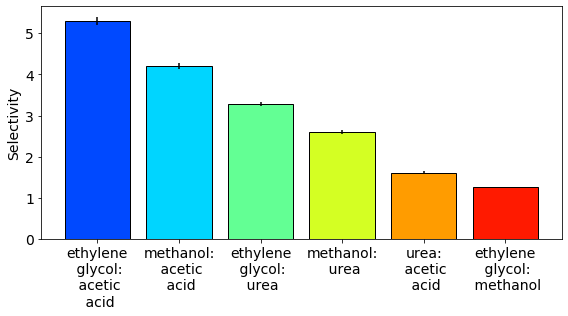

In [5]:
save = True
if save:
    savename = '/home/ben/github/LLC_Membranes/Ben_Manuscripts/hdphmm/figures/selectivity2.pdf'
else:
    savename = None
    
startfit = 10
endfit = 50

ratios = np.array([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]])
ratios = np.array([[1, 3], [0, 3], [1, 2], [0, 2], [2, 3], [1, 0]])  # in order from highest to lowest selectivity

solutes = ['MET', 'GCL', 'URE', 'ACH']
# solutes = ['GCL']

fig = selectivity(solutes, params, ratios, savename=savename, cmap=plt.cm.jet, startfit=startfit, endfit=endfit, 
           show_fits=False, nboot=200)

In [ ]:
savename = '/home/ben/github/LLC_Membranes/Ben_Manuscripts/hdphmm/figures/selectivity2.pdf'
fig.savefig(savename)
